In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib
import fsspec
from helper import calc_local_roughness

# import fancy plotting
import json
plt.rcParams.update(json.load(open("plot_settings.json")))


In [3]:
ds = xr.open_dataset('../data/training.nc')

ds_new = calc_local_roughness(ds)
ds_new_flat = ds_new.stack(z=('x', 'y', 'time'))
ds_new_flat = ds_new_flat.chunk({'z' : 100_000})


In [4]:
X1 = ds_new_flat.isel(band=0)['BT_2D']
X2 = ds_new_flat.isel(band=1)['BT_2D']
X3 = ds_new_flat.isel(band=2)['BT_2D']
X4 = ds_new_flat.isel(band=3)['BT_2D']
X5 = ds_new_flat.isel(band=4)['BT_2D']

X6 = ds_new_flat['sur_rgh']
X7 = ds_new_flat['neighbor_mean']
X8 = ds_new_flat['neighbor_std']

group = ds_new_flat.time.dt.dayofyear
y = ds_new_flat['label']
sample = ds_new_flat['time']


In [5]:
ds_training = xr.Dataset(
    data_vars=dict(
        y=(['z'],   y.values),
        X1=(['z'], X1.values),
        X2=(['z'], X2.values),
        X3=(['z'], X3.values),
        X4=(['z'], X4.values),
        X5=(['z'], X5.values),
        X6=(['z'], X6.values),
        X7=(['z'], X7.values),
        X8=(['z'], X8.values),
        group=(['z'], group.values),
        sample=(['z'], sample.values),
    ),
    coords=dict(
        z=np.arange(len(ds_new_flat.z)),
    ),
)

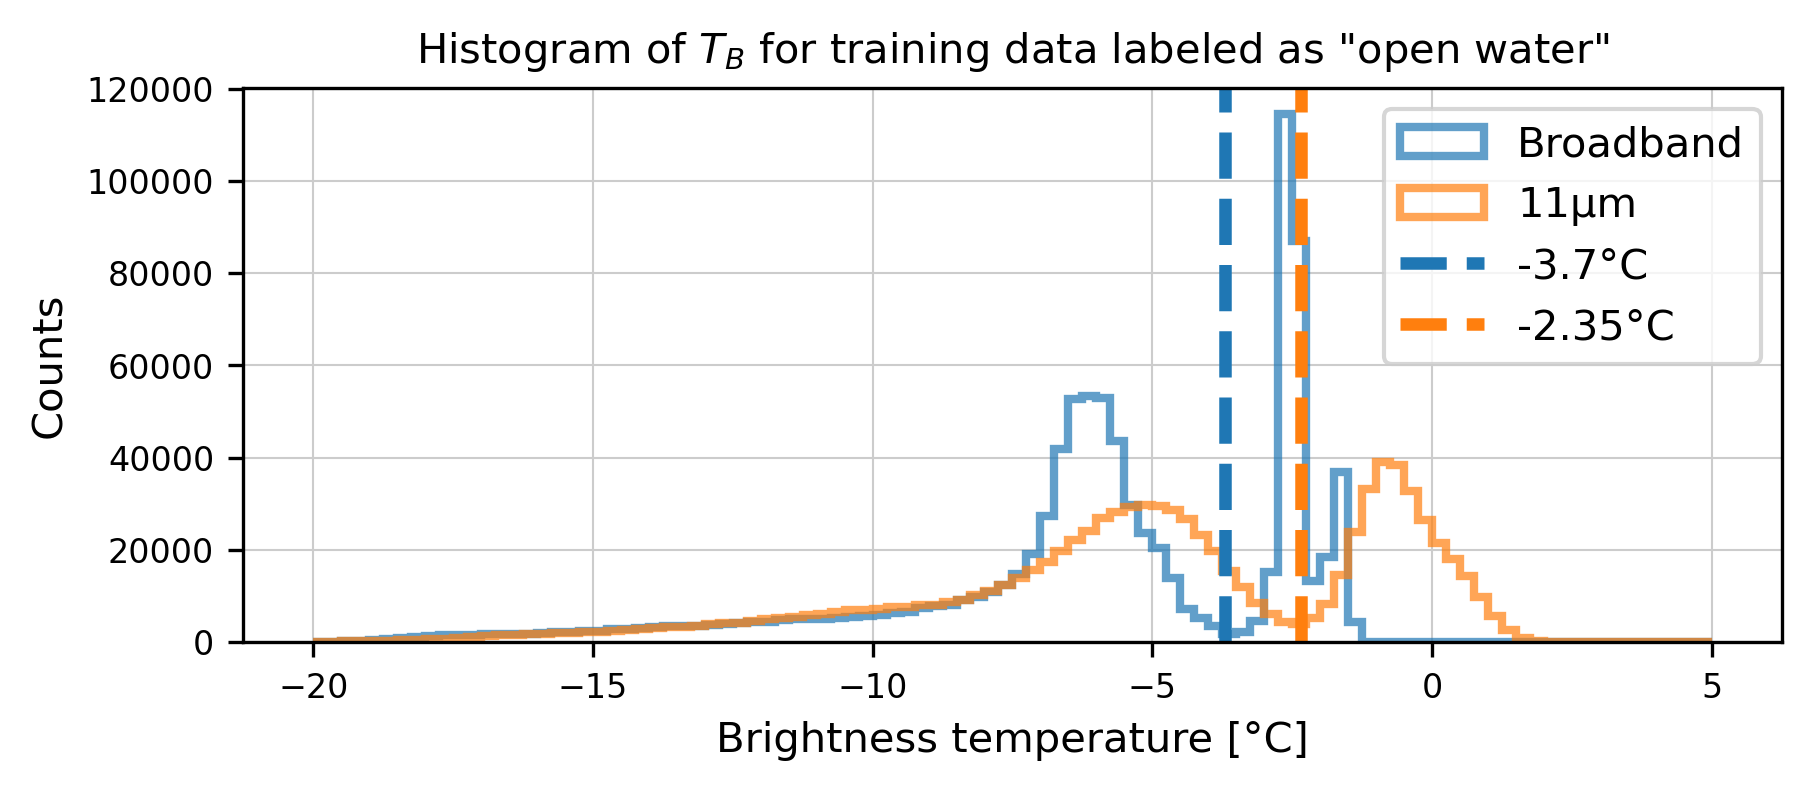

In [6]:
ds_training.X1.where(ds_training.y == 1).plot.hist(bins=100, alpha=.7, label='Broadband', range=(-20,5), histtype='step', lw=2)
ds_training.X5.where(ds_training.y == 1).plot.hist(bins=100, alpha=.7, label='11µm', range=(-20,5), histtype='step', lw=2)

plt.axvline(-3.7, color='C0', linestyle='--', label='-3.7°C')
plt.axvline(-2.35, color='C1', linestyle='--', label='-2.35°C')

plt.title('Histogram of $T_B$ for training data labeled as "open water"')
plt.xlabel('Brightness temperature [°C]')
plt.ylabel('Counts')

plt.legend()
plt.show()


In [7]:
ds_training.to_netcdf('../data/training_flat.nc', mode='w')
xr.open_dataset('../data/training_flat.nc')

<xarray.Dataset>
Dimensions:  (z: 20282535)
Coordinates:
  * z        (z) int64 0 1 2 3 4 ... 20282531 20282532 20282533 20282534
Data variables:
    y        (z) uint8 ...
    X1       (z) float32 ...
    X2       (z) float32 ...
    X3       (z) float32 ...
    X4       (z) float32 ...
    X5       (z) float32 ...
    X6       (z) float64 ...
    X7       (z) float64 ...
    X8       (z) float64 ...
    group    (z) int64 ...
    sample   (z) datetime64[ns] ...

In [8]:
ds_training = xr.open_dataset('../data/training_flat.nc', chunks={'z': 1_000_000})
ds_training['y'] = xr.where(ds_training.y == 0, np.nan, ds_training['y'])
ds_training['y'] = xr.where(ds_training.y == 3, np.nan, ds_training['y'])
#ds_training = ds_training.dropna(dim='z', how='any')

In [9]:
ds_training['y_corrected'] = ds_training.y
ds_training['y_corrected'] = xr.where((ds_training.X1 < -3.7) & (ds_training.y == 1), 2, ds_training.y_corrected)
ds_training['y_corrected'] = xr.where(ds_training.y == 4, 3, ds_training.y_corrected)
ds_training['y_corrected'] = xr.where((ds_training.X1 < -27) & (ds_training.y == 2), 3, ds_training.y_corrected)

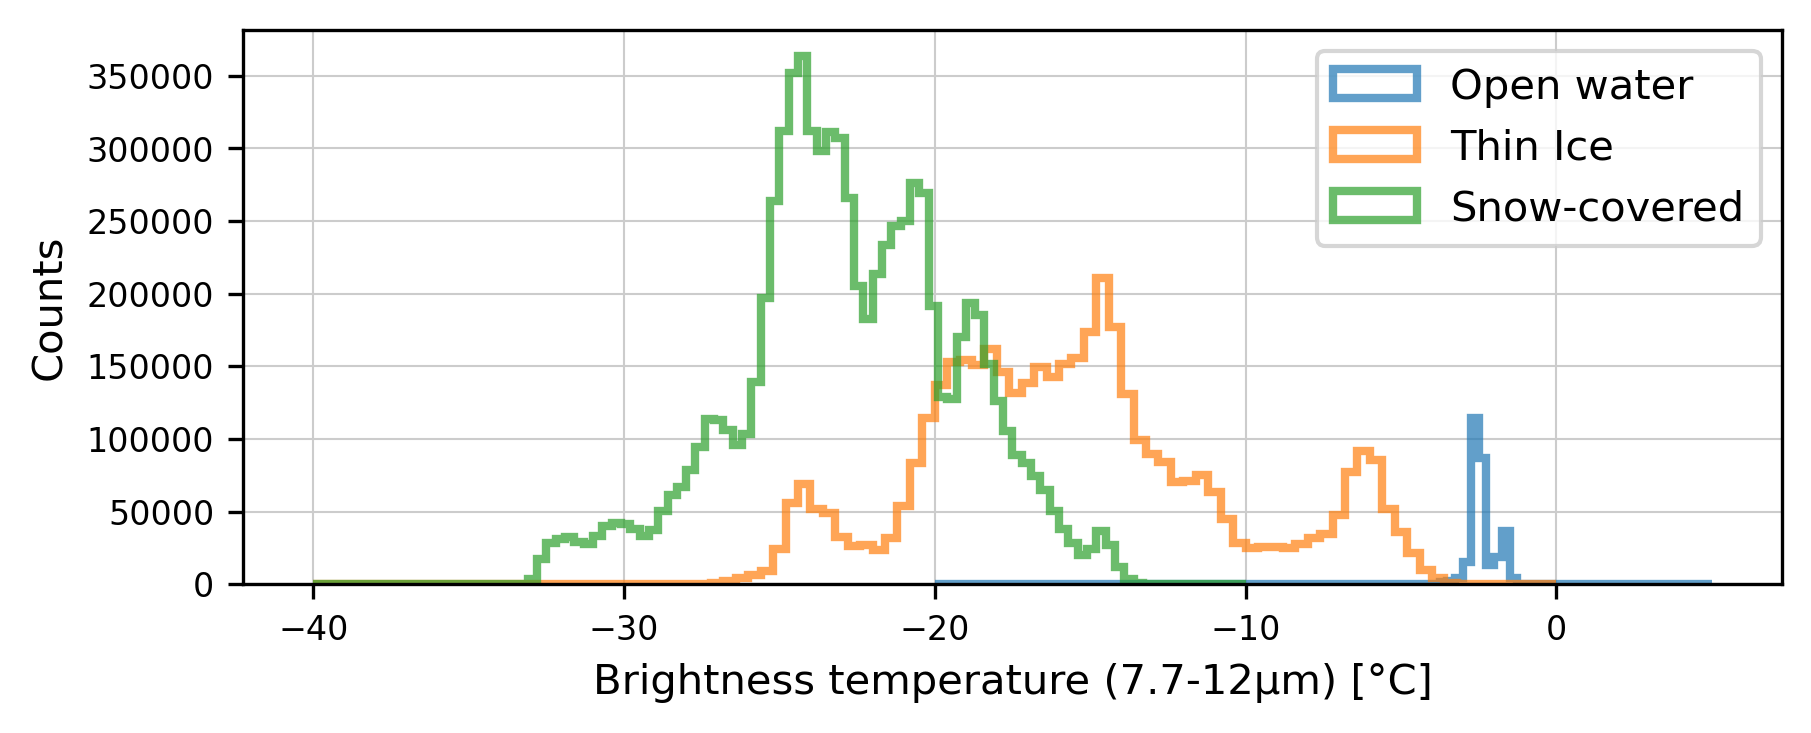

In [10]:
ds_training['X1'].where(ds_training.y_corrected == 1).plot.hist(bins=100, alpha=.7, label='Open water', range=(-20,5), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y_corrected == 2).plot.hist(bins=100, alpha=.7, label='Thin Ice', range=(-40, 0), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y_corrected == 3).plot.hist(bins=100, alpha=.7, label='Snow-covered', range=(-40, -10), histtype='step', lw=2)
plt.legend()
plt.xlabel('Brightness temperature (7.7-12µm) [°C]')
plt.ylabel('Counts')
plt.show()

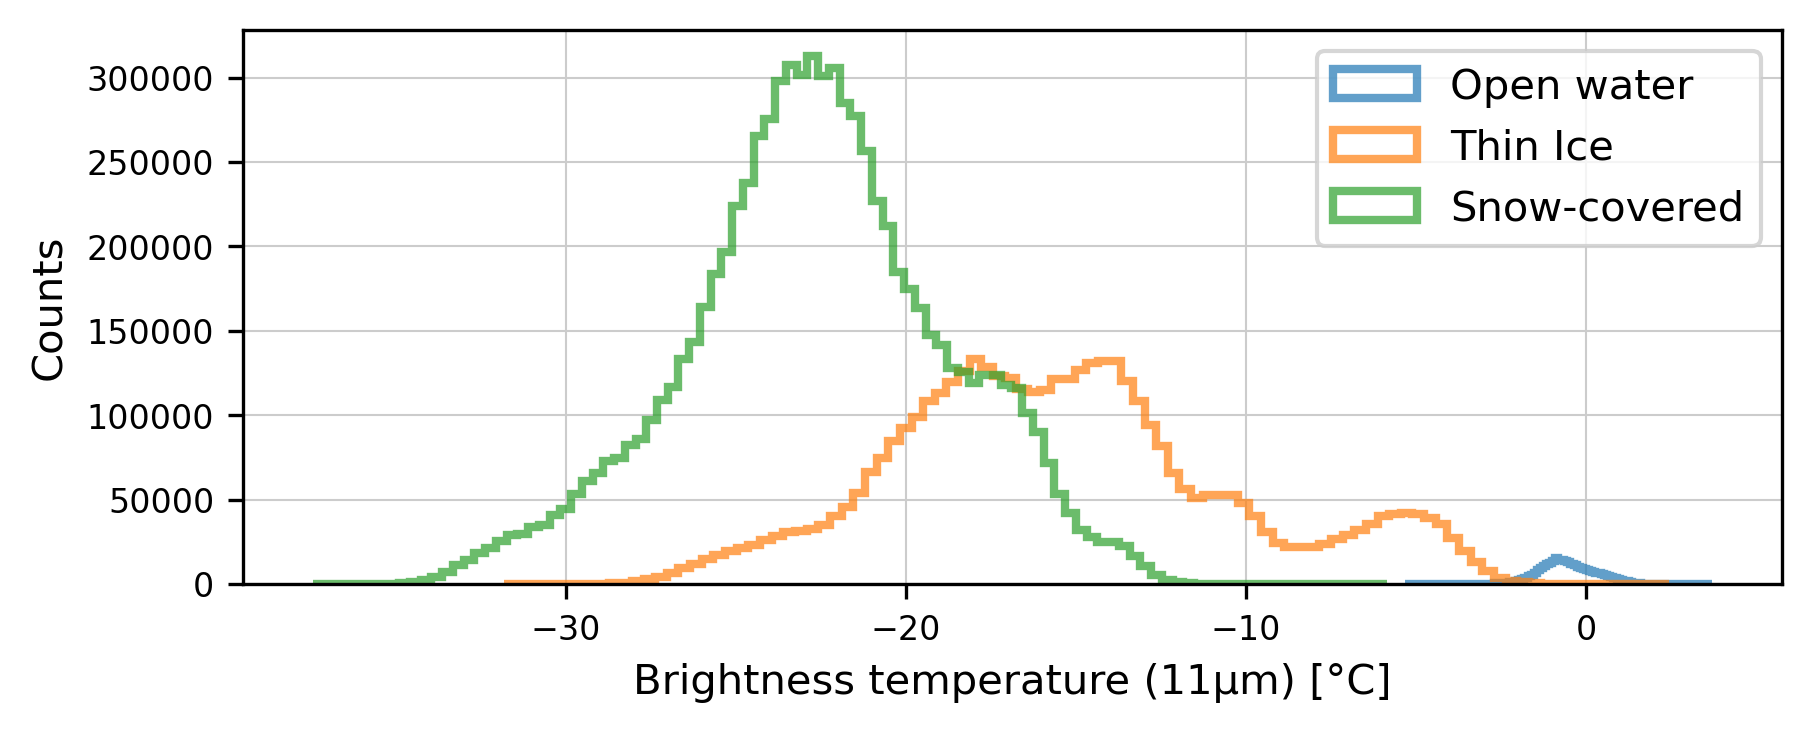

In [11]:
ds_training['X5'].where(ds_training.y_corrected == 1).plot.hist(bins=100, alpha=.7, label='Open water', histtype='step', lw=2)
ds_training['X5'].where(ds_training.y_corrected == 2).plot.hist(bins=100, alpha=.7, label='Thin Ice', histtype='step', lw=2)
ds_training['X5'].where(ds_training.y_corrected == 3).plot.hist(bins=100, alpha=.7, label='Snow-covered', histtype='step', lw=2)
plt.legend()
plt.xlabel('Brightness temperature (11µm) [°C]')
plt.ylabel('Counts')
plt.show()

In [12]:
ds_training.to_netcdf('../data/training_flat_corrected.nc', mode='w', engine='h5netcdf')